In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# defining simulation parameters
k_bar = 15
eps = 1e-4
N = 10000
T_max = 200

k_init = np.linspace(0, k_bar, N) + eps
k_init = k_init.reshape(N, 1)

k_prime = np.linspace(0, k_bar, N) + eps
k_prime = k_prime.reshape(1, N)

constants = {
    "k": k_init, 
    "k_prime": k_prime,
    "alpha": 0.3,
    "gamma": 2,
    "delta": 0.05,
    "beta": 0.95,
}

In [82]:
def calculate_value_grid(
    k: np.ndarray,
    alpha: float,
    gamma: float,
    delta: float,
    beta: float,
    k_prime: np.ndarray,
    v_next: np.ndarray,
):
    """Computes a grid of utility payoffs

    Parameters
    ----------
        k np.ndarray:
            N X 1 array of values to compute K_init over

        k_prime np.ndarray:
            1 X N array of values to compute K_prime over

    Returns
    -------
        N X N  array of computed values

    """
    c = k**alpha + (1 - delta) * k - k_prime
    U = np.full_like(c, -np.inf, dtype=float)

    # ensures k_prime <= k^alpha + (1-delta) * k
    feasibilty_mask = c > 0

    U[feasibilty_mask] = (np.power(c[feasibilty_mask], 1 - gamma) - 1) / (1 - gamma)
    v_next_col = np.asarray(v_next).reshape(1, -1)

    return U + beta * v_next_col


def bellman_operator(value_function: callable, v_arr: np.ndarray, **kwargs): 
    """Computes a single iteration of the bellman operator. 

    Parameters
    ----------
    value_function: callable
        value_function 
    
    v_next_arr: np.ndarray 
        (N,) array of previous maximum guess 

    **kwargs
        keyword arguments to properly specify the value_function grid
    """
    v_mat = value_function(v_next=v_arr, **kwargs)
    
    argmax_v_mat = np.argmax(v_mat, axis=1)
    v_arr_next = np.max(v_mat, axis=1)

    return argmax_v_mat, v_arr_next


In [ ]:
def infinite_horizon_value_function_iteration(convergence_eps: float):
    """Solves the infinite horizon"""

    # initialize guess
    v_max_array = np.full(N, 2)
    i = 1

    while True:
        argmax_v_mat, v_max_array_new = bellman_operator(calculate_value_grid, v_max_array, **constants)

        dist = np.max(np.abs(v_max_array_new - v_max_array))
        print(f"Iteration {i}, Distance {dist}")

        v_max_array = v_max_array_new
        i += 1

        if dist <= convergence_eps:
            break
    
    return argmax_v_mat, v_max_array


def g(k, optimal_index):
    """Discretized policy function"""
    k_discrete_idx = np.argmin(np.abs(k_init - k))
    return k_prime.ravel()[optimal_index[k_discrete_idx]]


def simulate_infinite(k0): 
    """Solve the infinite horizon problem"""
    # The homeworks asks to go to 1e-10 tolerance, but I don't have time for that, results are stable enough here 
    argmax_v_mat, _ = infinite_horizon_value_function_iteration(convergence_eps=1e-3)

    ks = np.zeros(T_max)
    cs = np.zeros(T_max - 1)

    ks[0] = k0 

    for t in range(1, T_max):
        ks[t] = g(ks[t-1], argmax_v_mat)
        cs[t - 1] = (
            ks[t-1] ** constants["alpha"] + (1 - constants["delta"]) * ks[t-1] - ks[t]
        )

    return ks, cs


ks_vfi, cs_vfi = simulate_infinite(3)

Iteration 1, Distance 14.95018796736157
Iteration 2, Distance 5.036201968299144
Iteration 3, Distance 2.2885274668567206
Iteration 4, Distance 1.3495106239188601
Iteration 5, Distance 0.904268500927845
Iteration 6, Distance 0.6468091060007595
Iteration 7, Distance 0.47738682147535627
Iteration 8, Distance 0.36791508021180874
Iteration 9, Distance 0.28925427333994946
Iteration 10, Distance 0.2301503013417694
Iteration 11, Distance 0.1886212745741762
Iteration 12, Distance 0.16693402394474788
Iteration 13, Distance 0.14818559079647198
Iteration 14, Distance 0.13190458944047379
Iteration 15, Distance 0.11770939053618967
Iteration 16, Distance 0.10528712953335084
Iteration 17, Distance 0.09438062118968205
Iteration 18, Distance 0.08477624986970067
Iteration 19, Distance 0.07629527005207581
Iteration 20, Distance 0.06878761378468212
Iteration 21, Distance 0.06212643056349165
Iteration 22, Distance 0.05620361457176237
Iteration 23, Distance 0.05092702492925216
Iteration 24, Distance 0.046217

In [98]:
def finite_horizon_solver(n_periods, alpha, delta, gamma, **kwargs):
    """Solves a finite horizon neoclassical model using backwards induction."""
    c_final = np.power(k_init, alpha) + (1 - delta) * k_init
    v_t_plus_1 = ((np.power(c_final, (1 - gamma)) - 1) / (1 - gamma)).ravel()

    optimal_index = np.zeros((n_periods, N), dtype=int)

    for t in range(n_periods-1, -1, -1):
        argmax_v_mat, v_max_array_new = bellman_operator(calculate_value_grid, v_t_plus_1, **constants)
        optimal_index[t, :] = argmax_v_mat

        v_t_plus_1 = v_max_array_new 

    return optimal_index


def g_finite(optimal_index, time_step, k):
    k_discrete_idx = np.argmin(np.abs(k_init.ravel() - k))
    return k_prime.ravel()[optimal_index[time_step, k_discrete_idx]]


def simulate_finite(k0, n_periods):
    optimal_index = finite_horizon_solver(n_periods, **constants)

    ks = np.zeros(n_periods + 1)
    cs = np.zeros(n_periods)
    ks[0] = k0

    for t in range(n_periods):
        k_next = g_finite(optimal_index, t, ks[t])
        cs[t] = ks[t]**constants["alpha"] + (1 - constants["delta"]) * ks[t] - k_next
        ks[t+1] = k_next

    return ks, cs


ks_finite_20, cs_finite_20 = simulate_finite(3, 20)
ks_finite_30, cs_finite_30 = simulate_finite(3, 30)
ks_finite_60, cs_finite_60 = simulate_finite(3, 60)
ks_finite_80, cs_finite_80 = simulate_finite(3, 80)

In [91]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["text.usetex"] = True

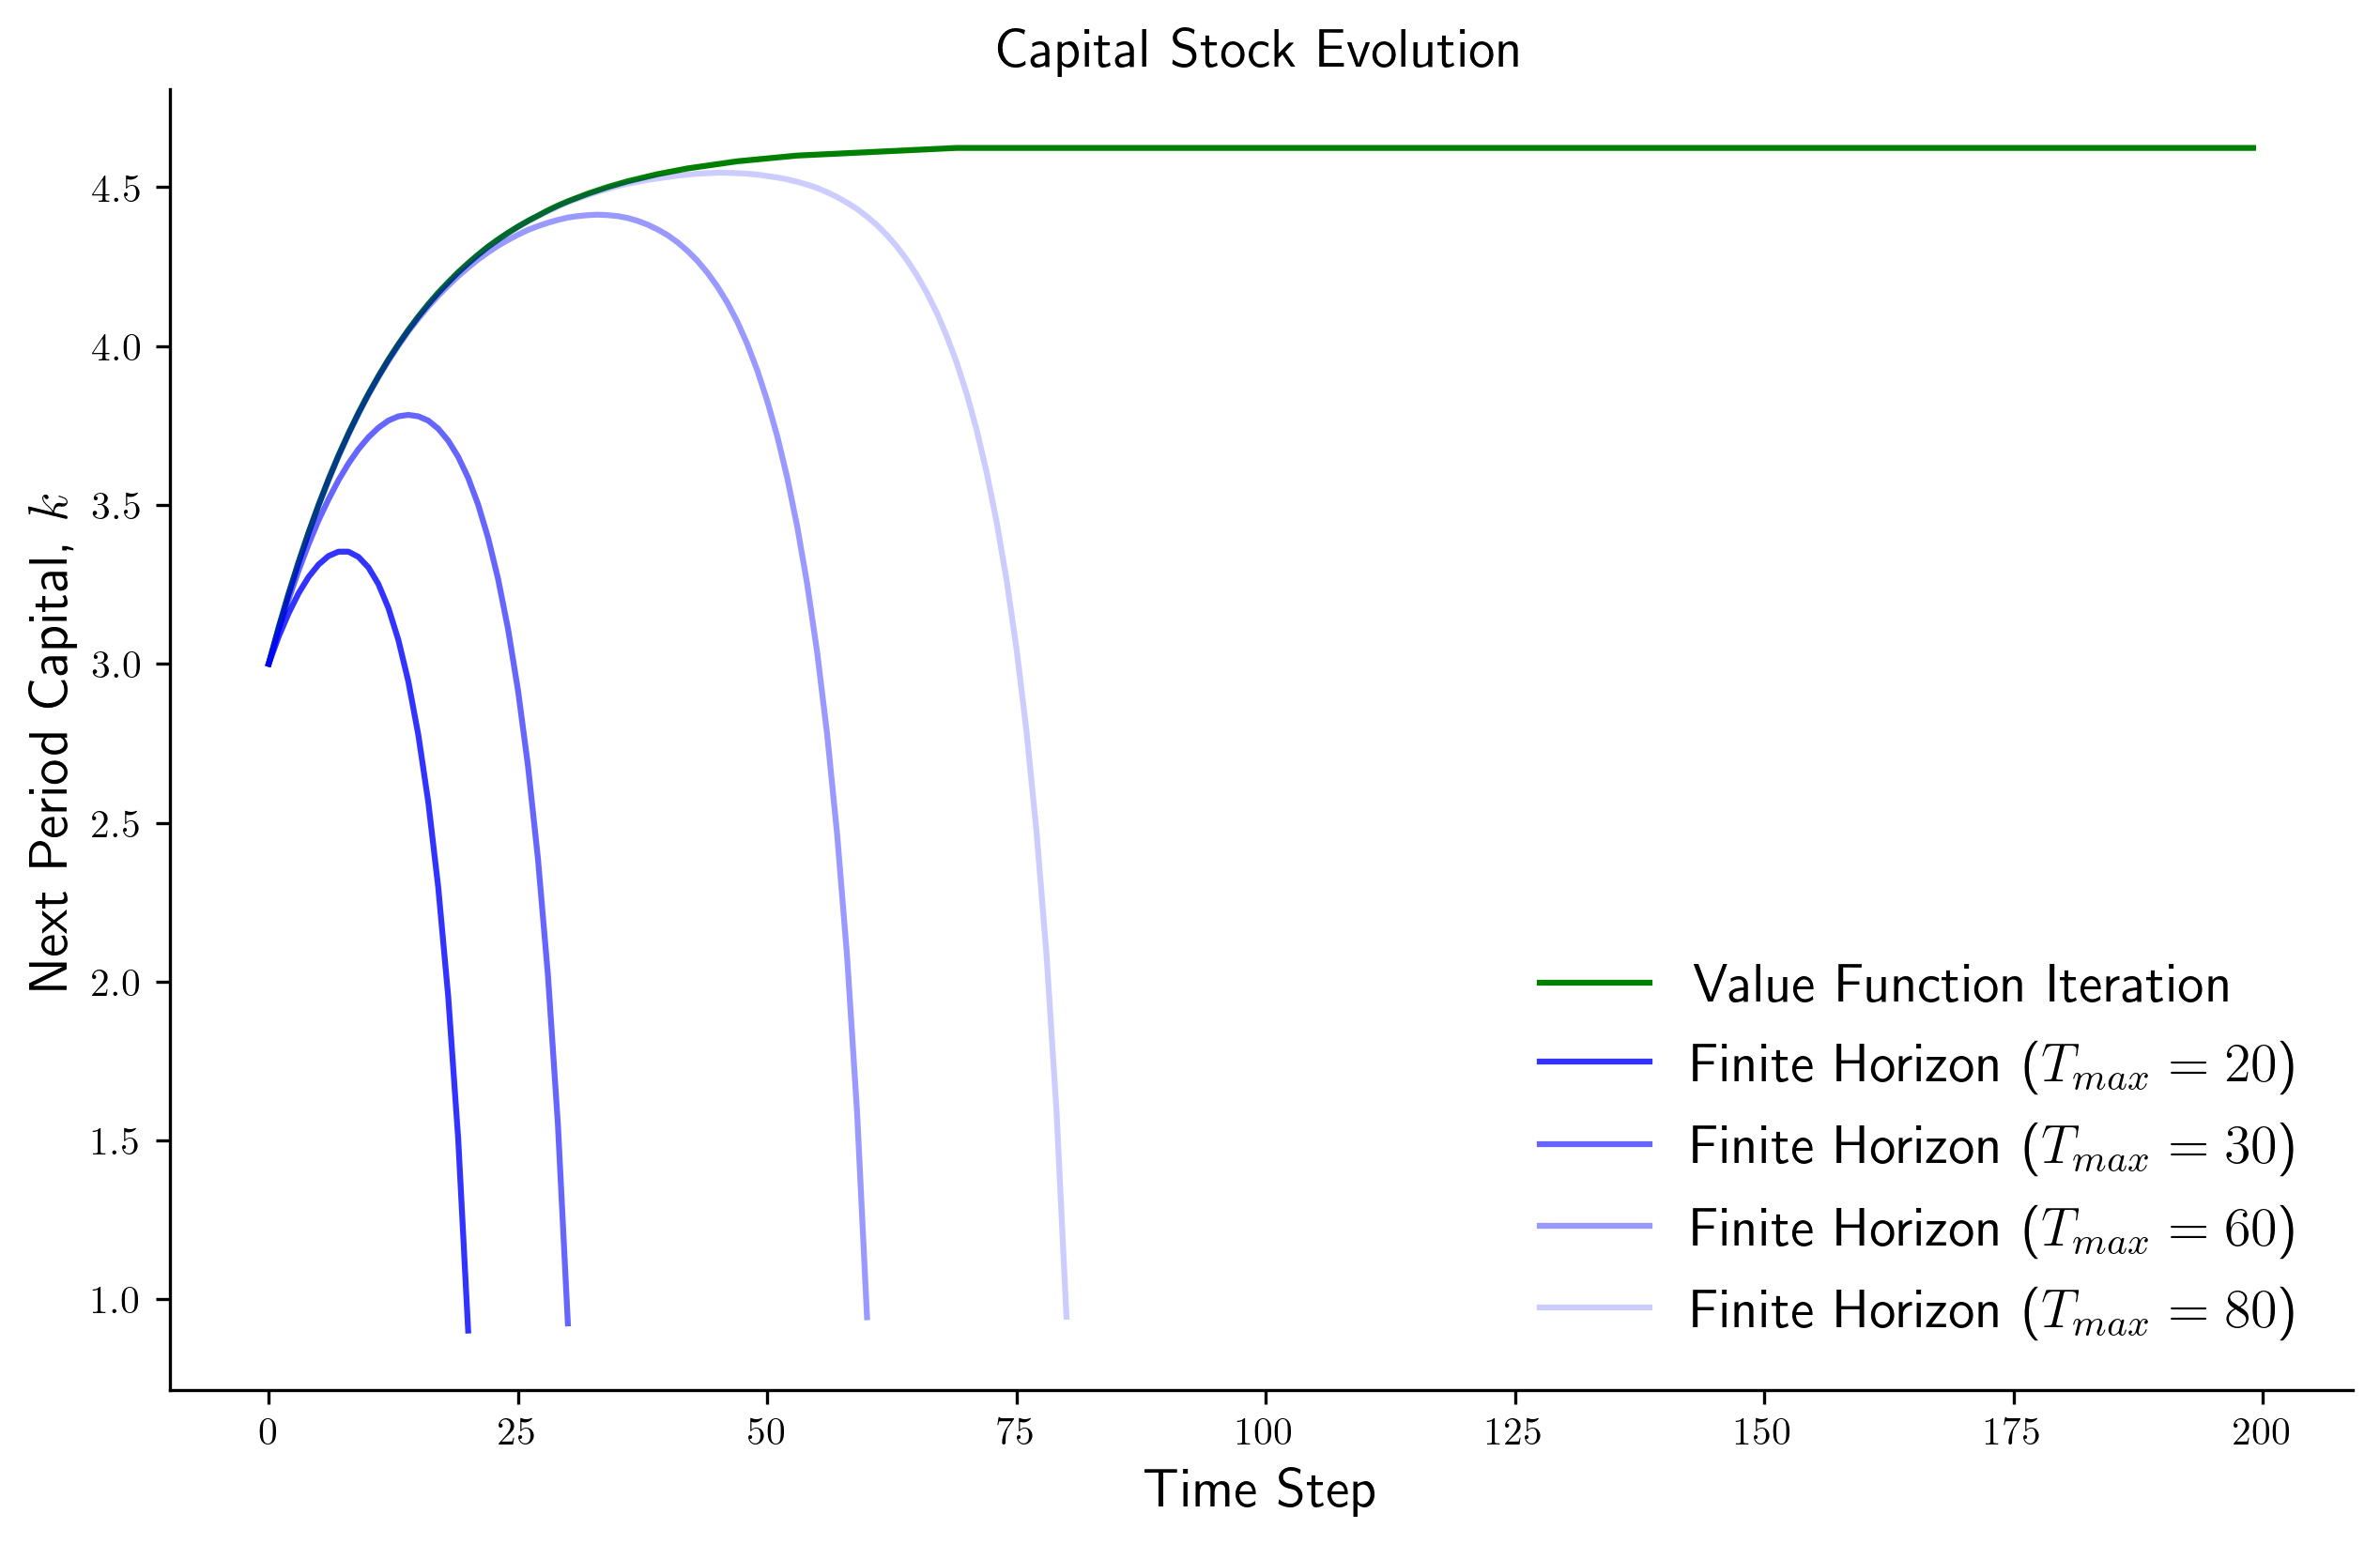

In [100]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.arange(len(ks_vfi)), ks_vfi, color="green", label="Value Function Iteration")
ax.plot(
    np.arange(len(ks_finite_20)), ks_finite_20, color="blue", alpha = 0.8,  label="Finite Horizon ($T_{{max}} = 20$)"
)
ax.plot(
    np.arange(len(ks_finite_30)), ks_finite_30, color="blue", alpha = 0.6, label="Finite Horizon ($T_{{max}} = 30$)"
)
ax.plot(
    np.arange(len(ks_finite_60)), ks_finite_60, color="blue", alpha = 0.4, label="Finite Horizon ($T_{{max}} = 60$)"
)
ax.plot(
    np.arange(len(ks_finite_80)), ks_finite_80, color="blue", alpha = 0.2, label="Finite Horizon ($T_{{max}} = 80$)"
)

ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Next Period Capital, $k$", size=14)
ax.set_xlabel("Time Step", size=14)
ax.set_title("Capital Stock Evolution", size=14)
ax.legend(frameon=False, fontsize=14)

plt.show()

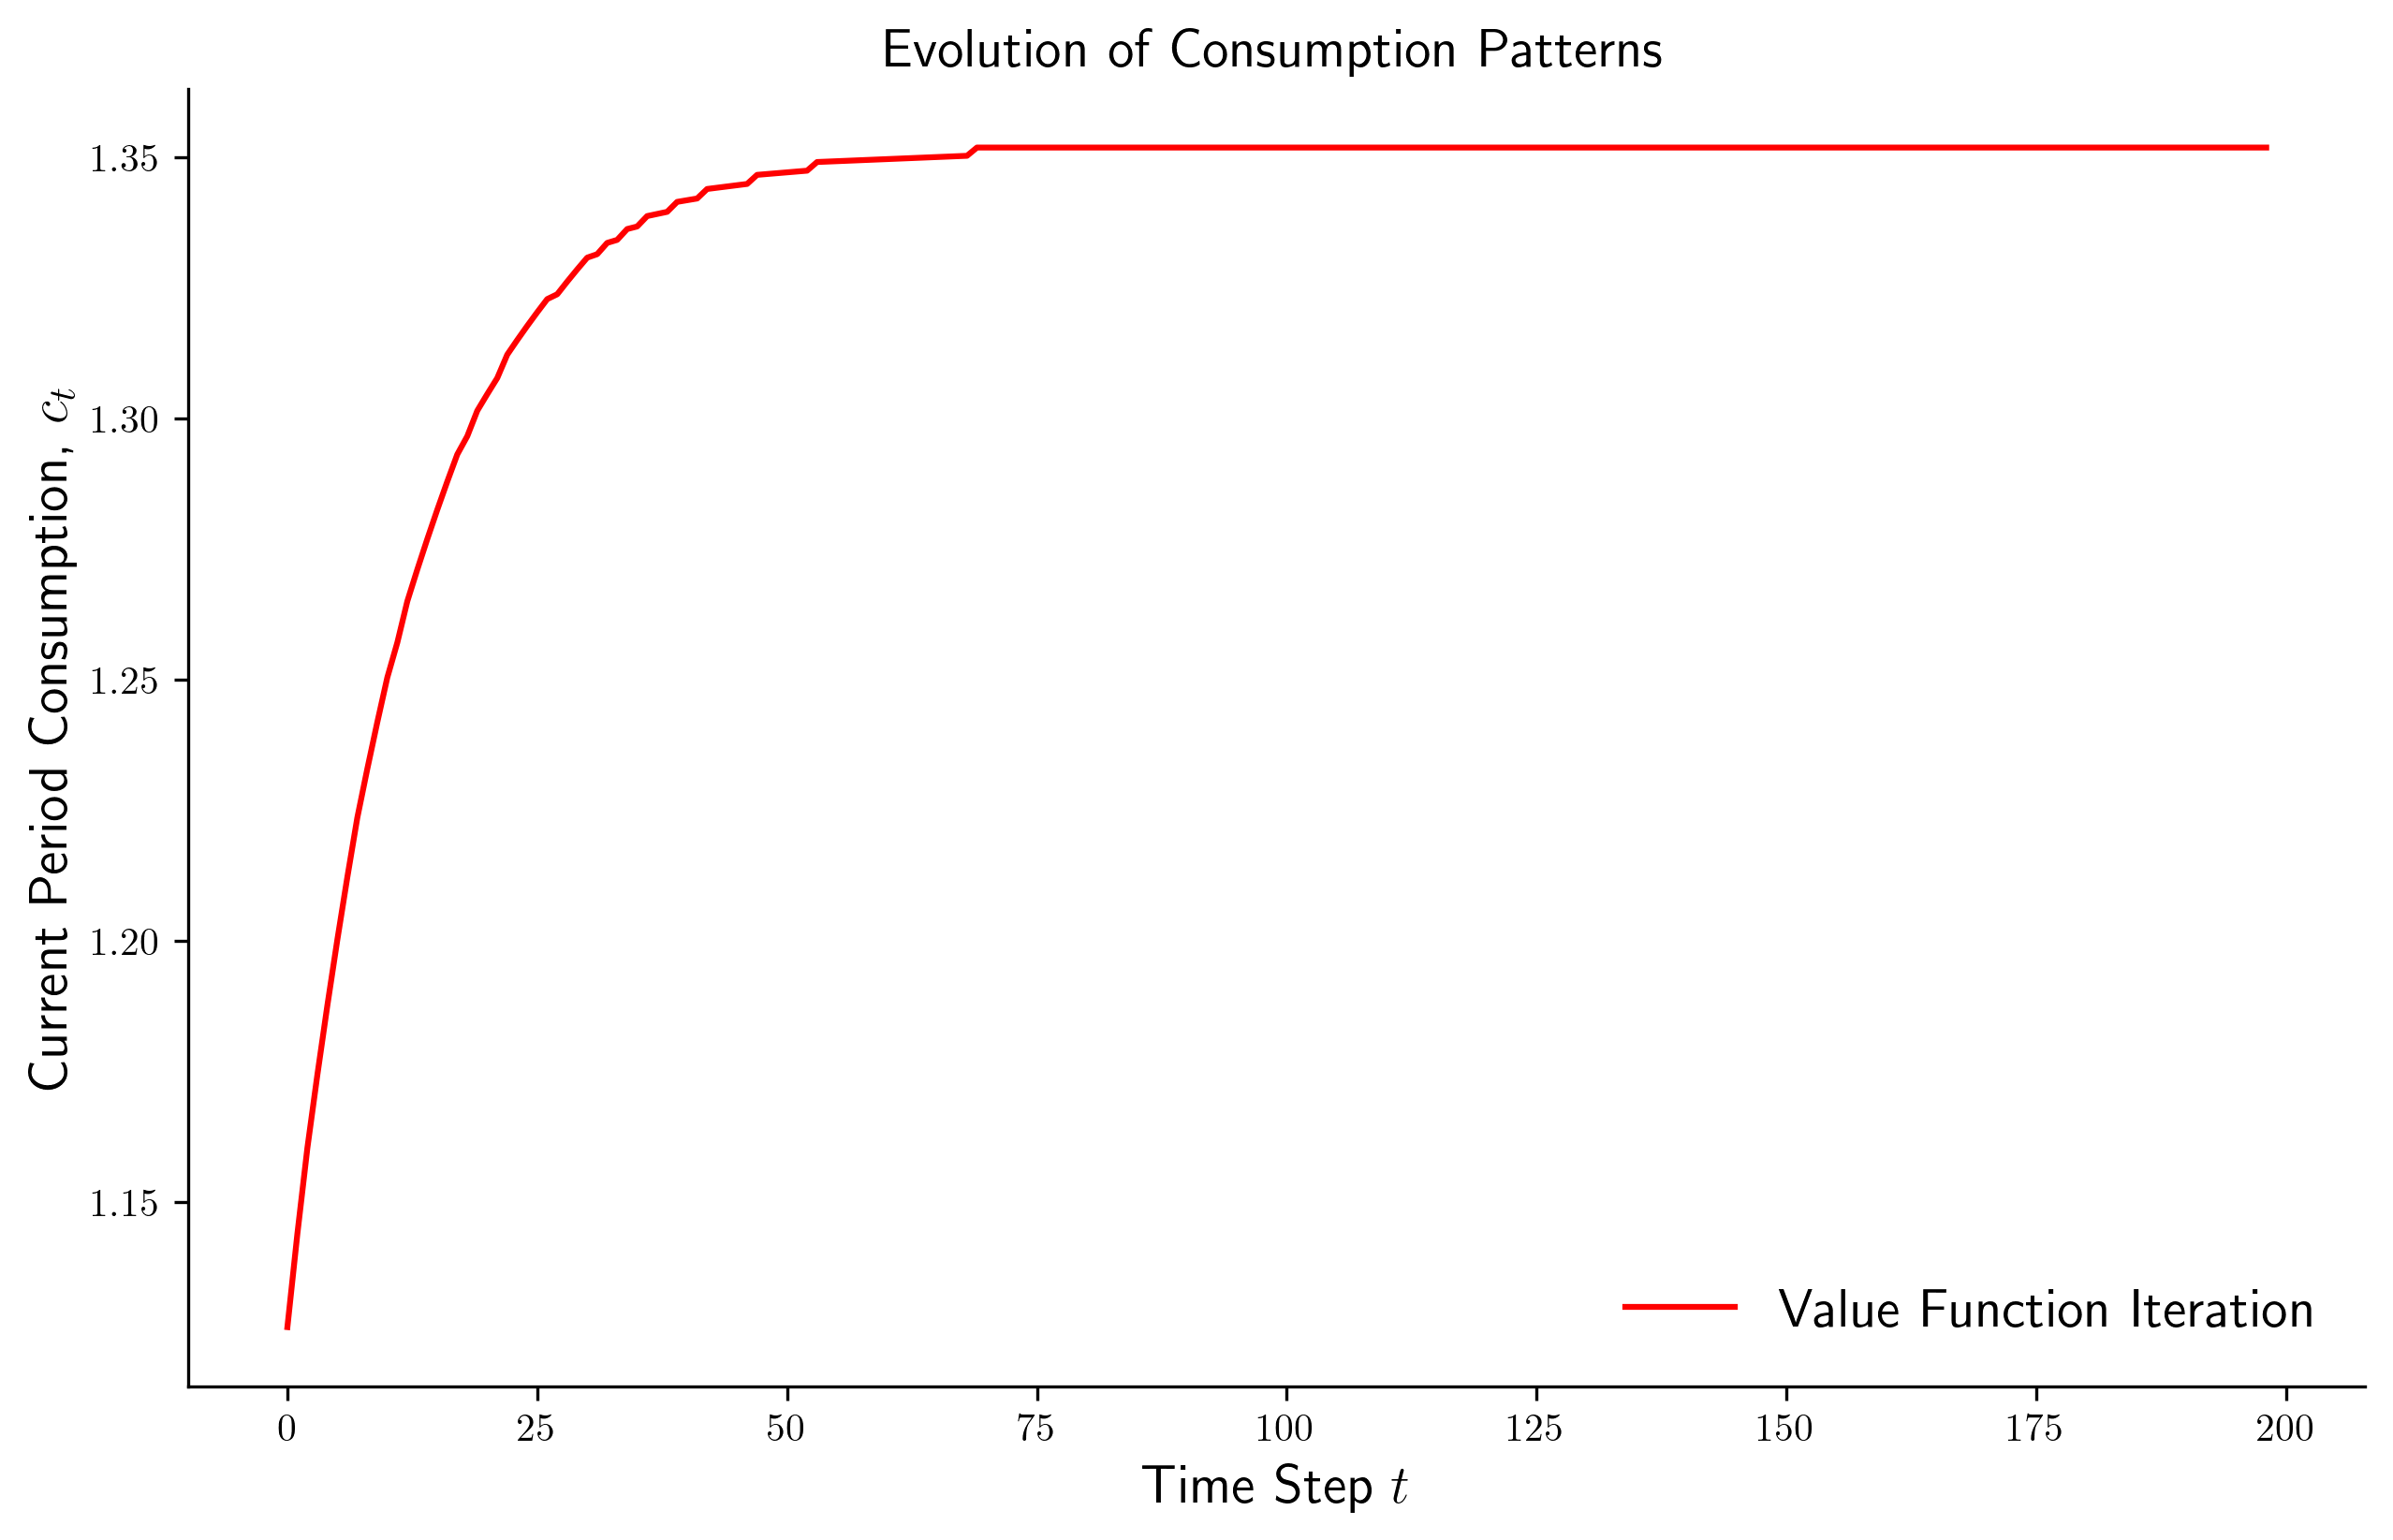

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(np.arange(T_max - 1), cs, color="red", label="Value Function Iteration")
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Current Period Consumption, $c_t$", size=14)
ax.set_xlabel("Time Step $t$", size=14)
ax.set_title("Evolution of Consumption Patterns", size=14)
ax.legend(frameon=False, fontsize=14)

plt.show()

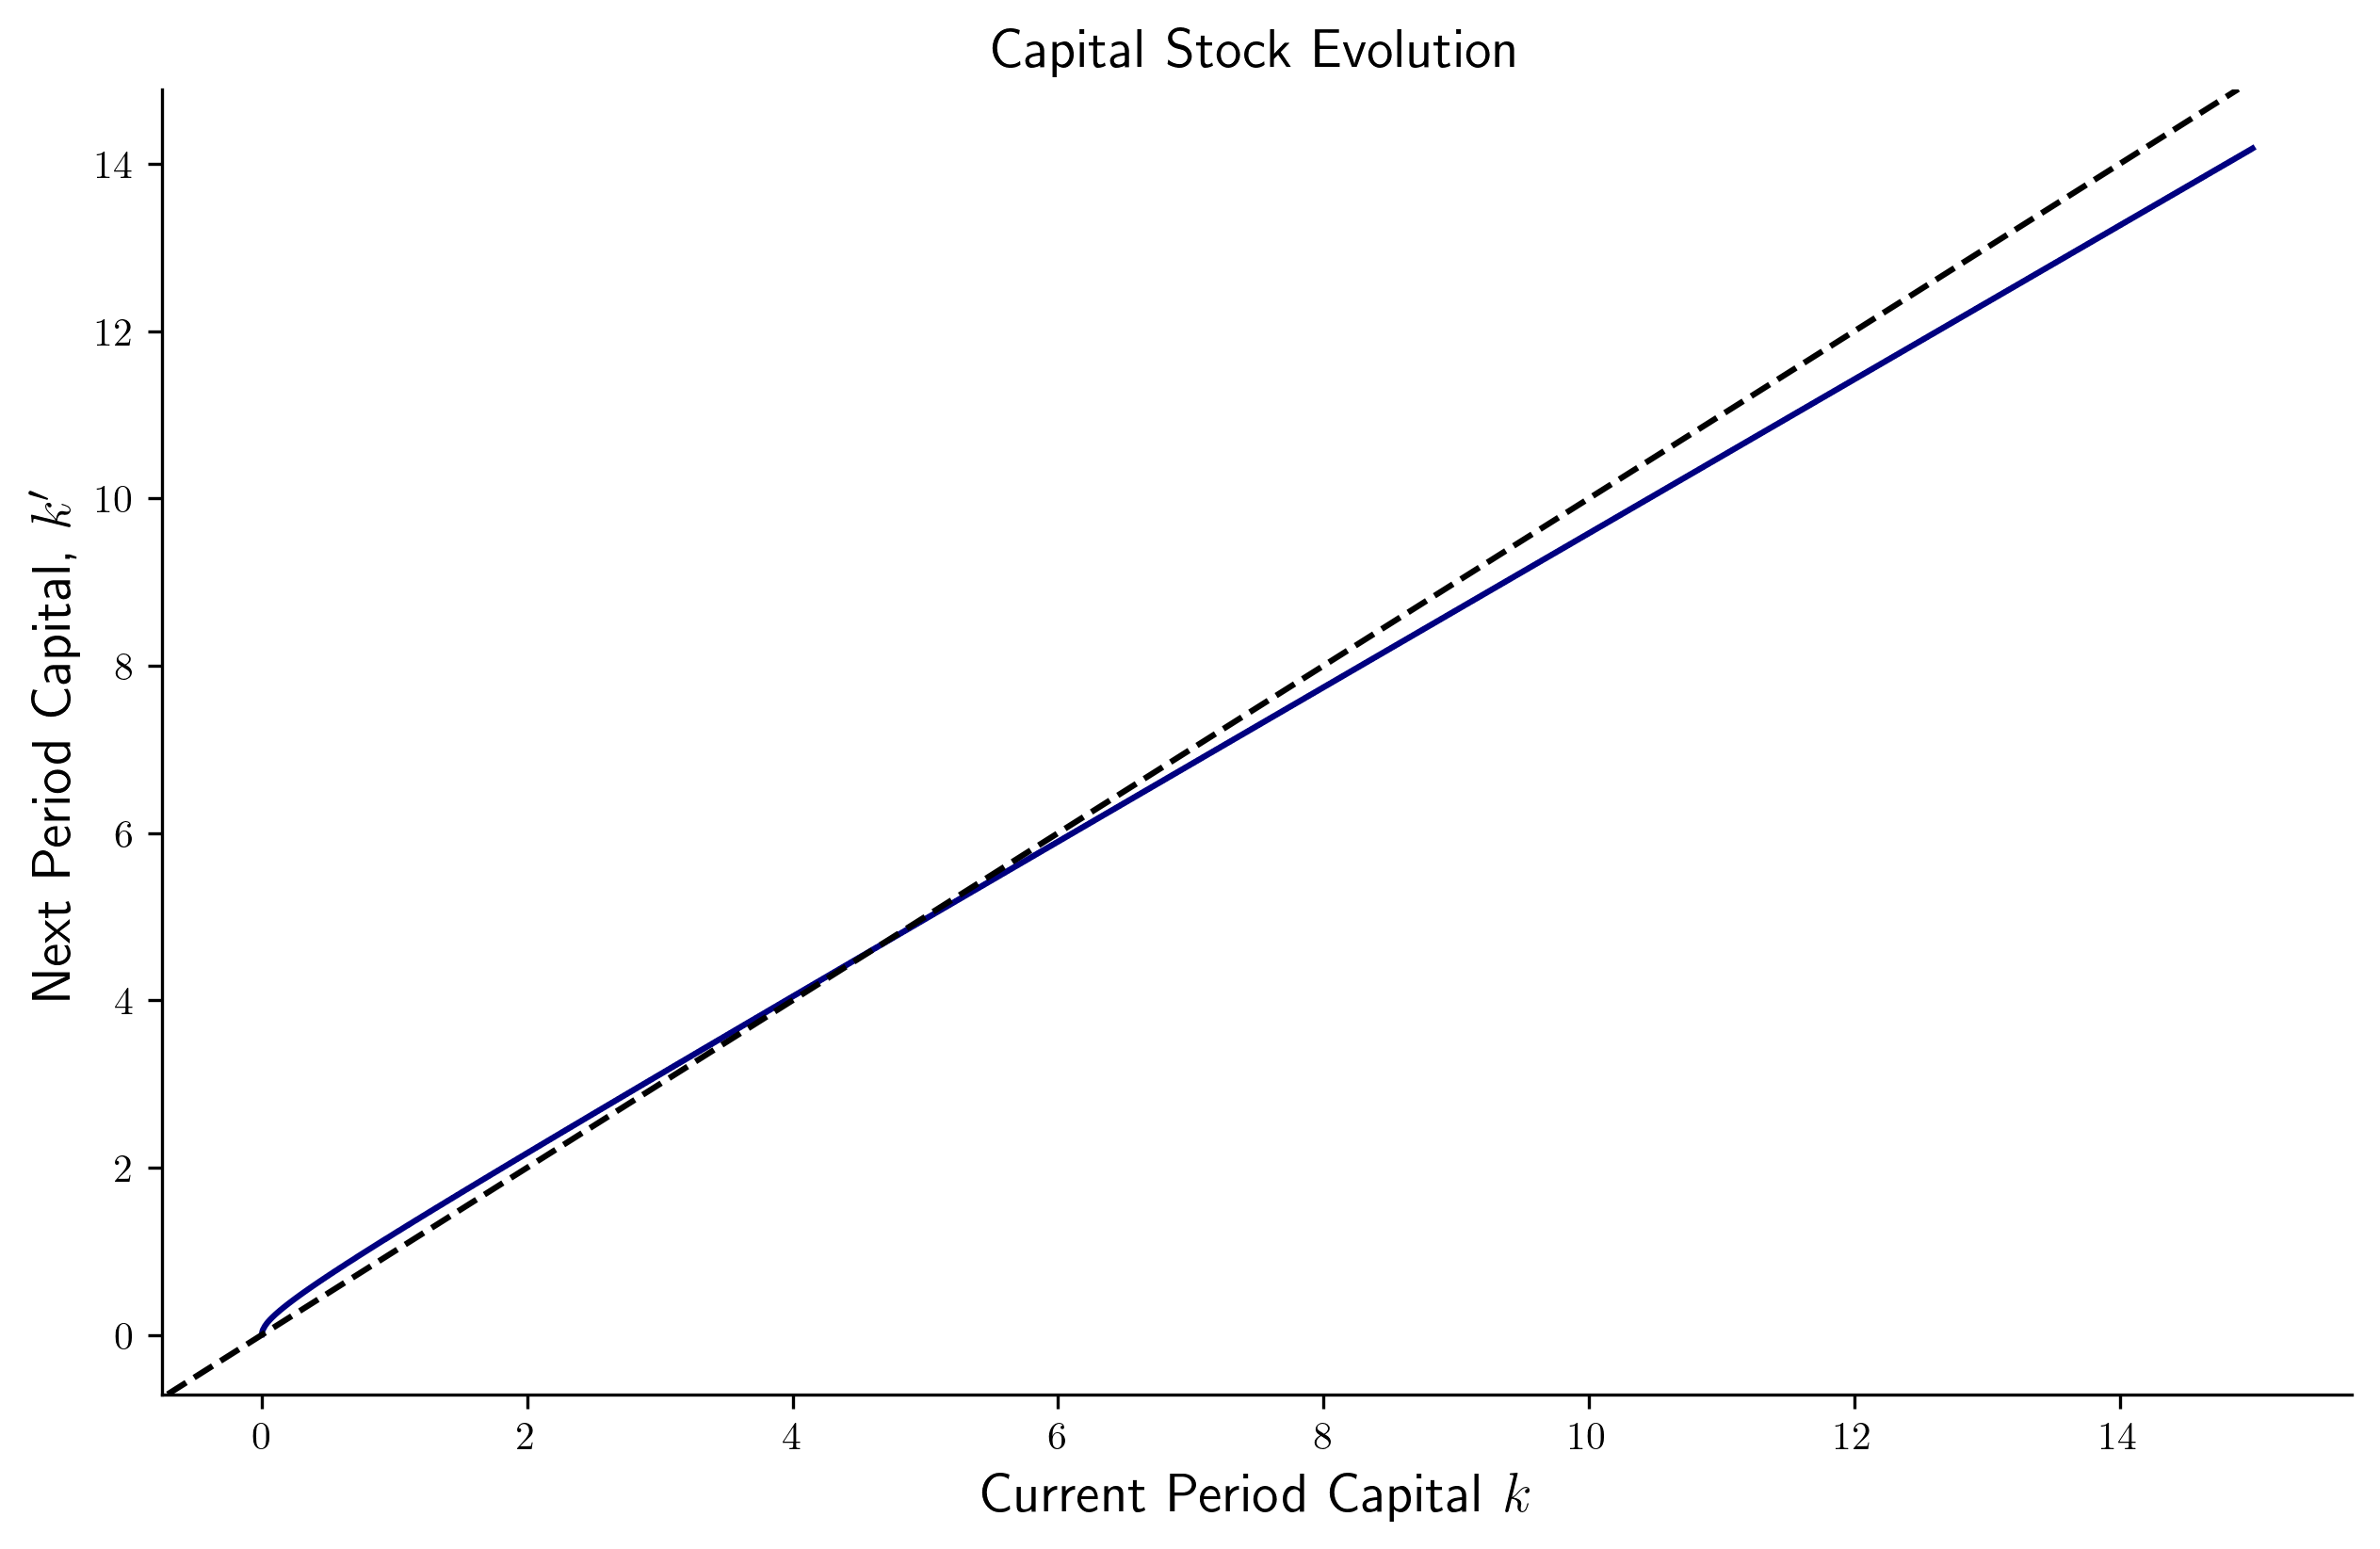

In [ ]:
k_optimal = [g(k) for k in k_init]
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(k_init.reshape(N), k_optimal, color="navy")
ax.spines[["top", "right"]].set_visible(False)
ax.set_ylabel("Next Period Capital, $k^\prime$", size=14)
ax.set_xlabel("Current Period Capital $k$", size=14)
ax.set_title("Capital Stock Evolution", size=14)
ax.axline(xy1=(0, 0), slope=1, linestyle="dashed", color="black")

plt.show()